In [1]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

from src.pipeline.base import load_pt_data, compile_astromer
from src.models        import get_ASTROMER_2, get_ASTROMER
from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# plt.style.use('dark_background')|

## Pretraining results

First we take an arbitrary config file from the `experiments_config_files` folder

In [14]:
mean_rmse = []
mean_rsquare = []
for exp in [1, 2]:
    for base in [1e3, 1e4]:
        print('-'*100)
        print(base)
        experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_{int(exp)}_{int(base)}/'
        with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
            config = tomli.load(fp)

        metrics = pd.read_csv(os.path.join(config['pretraining']['exp_path'], 'metrics.csv'))
        print(metrics)
        loss = metrics['rmse'].values[0]
        r2 = metrics['r_square'].values[0]

        mean_rmse.append(loss)
        mean_rsquare.append(r2)

----------------------------------------------------------------------------------------------------
1000.0
       rmse  r_square         step                 time
0  0.156758  0.790787  pretraining  2023-02-10 20:15:55
----------------------------------------------------------------------------------------------------
10000.0
       rmse  r_square         step                 time
0  0.156123  0.810767  pretraining  2023-02-10 22:40:20
----------------------------------------------------------------------------------------------------
1000.0
       rmse  r_square         step                 time  target  fold   spc
0  0.153699  0.794870  pretraining  2023-02-09 20:17:34     NaN   NaN   NaN
1  0.131062  0.737865   finetuning  2023-02-13 14:21:04  alcock   0.0  20.0
----------------------------------------------------------------------------------------------------
10000.0


FileNotFoundError: [Errno 2] No such file or directory: './presentation/experiments/astromer_2/results/macho_2_10000/pretraining/metrics.csv'

Text(0.5, -0.05, 'Exponent $\\alpha$ from $base^{(\\alpha j/D_{pe})}$ the positional encoder')

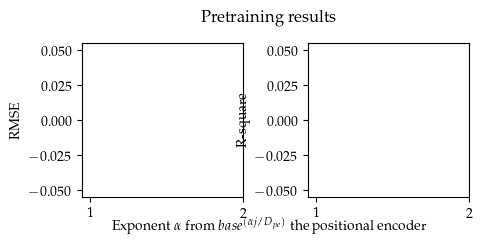

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.4}, figsize=(5, 2))

x_range = np.arange(0, 2)
axes[0].bar(x_range, mean_rmse)
# axes[0].set_ylim(0.14, 0.165)

axes[1].bar(x_range, mean_rsquare)
axes[1].set_xticks(x_range, [1, 2])
# axes[1].set_ylim(0.5, 0.7)

axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('R-square')

fig.suptitle('Pretraining results', x=0.5, y=1.05)
fig.text(0.5, -0.05, r'Exponent $\alpha$ from $base^{(\alpha j/D_{pe})}$ the positional encoder', ha='center')

In [6]:
'./presentation/experiments/astromer_2/config_files/macho/'

'./presentation/experiments/astromer_2/config_files/macho/'

In [18]:
import itertools



[INFO] Using custom scheduler
[INFO] Using custom scheduler
[INFO] Using custom scheduler
[INFO] Using custom scheduler


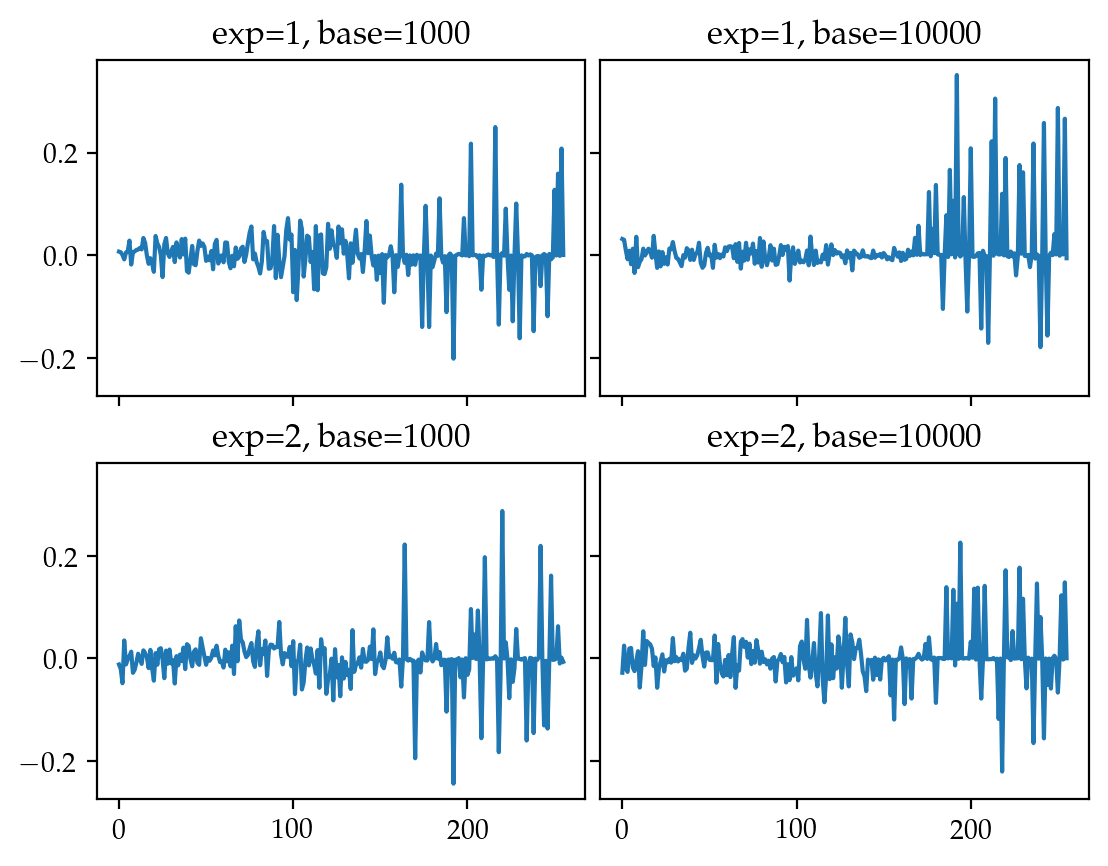

In [25]:
fig, axes = plt.subplots(2, 2, gridspec_kw={'hspace': 0.2, 'wspace': 0.03},
                         sharey=True, sharex=True, dpi=200)
iterables = itertools.product(*[[1, 2], [1000, 10000]])

for tuplex, ax in zip(iterables, axes.flatten()):
    experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_{tuplex[0]}_{tuplex[1]}'
    with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
        config = tomli.load(fp)

    d_model = config['astromer']['head_dim']*config['astromer']['heads']
    astromer =  get_ASTROMER_2(num_layers=config['astromer']['layers'],
                               d_model=d_model,
                               num_heads=config['astromer']['heads'],
                               dff=config['astromer']['dff'],
                               base=config['positional']['base'],
                               dropout=config['astromer']['dropout'],
                               maxlen=config['astromer']['window_size'],
                               pe_c=base)

    astromer = compile_astromer(config, astromer, step='pretraining')
    astromer.load_weights(os.path.join(config['finetuning']['weights'], 'weights'))
    encoder = astromer.get_layer('encoder')

    W = encoder.inp_transform.weights[0]
    ax.set_title('exp={}, base={}'.format(tuplex[0],tuplex[1]))
    ax.plot(W[0])


## Finetuning results

Use `collect_metrics` to join all the metrics associated with the experiments in 
`./presentation/pipeline/config/<experiment>`

By default it gives **finetuning** metrics. Use `clasification=True` for getting classification metrics 

In [23]:
experiments_config_files

'./presentation/experiments/astromer_2/config_files/macho_2'

In [25]:
# metrics_ft = collect_metrics(experiments_config_files, step='finetuning')

In [12]:
metrics_ft.groupby('case').mean()

,rmse,r_square
case,,
a,0.120343,0.70457
b,0.120343,0.70457


## Metrics by number of samples per class

Defining plot styles for the classifiers

In [26]:
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'-'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'--'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}

In [27]:
selected_metric = 'f1'
experiments_config_files

'./presentation/experiments/astromer_2/config_files/macho_2'

In [28]:
root_path_exp = './presentation/experiments/astromer_2/config_files/macho_1/'

In [29]:
for x in ['alcock_pe_1', 'alcock_pe_2']:
    current_path = os.path.join(root_path_exp, x)
    metrics = collect_metrics(experiments_config_files, step='classification', cases=['a'])
    
    for row, (dataset_name, frame_0) in enumerate(metrics.groupby('ft_data')):
        print(dataset_name)
        metrics_by_case = frame_0.groupby('case')
        for col, (sci_case, frame_1) in enumerate(metrics_by_case):
            metrics_by_model = frame_1.groupby('model')
            best_baseline = []
            
            for model_name, frame_2 in metrics_by_model:
                frame_2['spc'] = frame_2['file'].apply(lambda x: int(x.split('.')[1]))
                metrics_by_spc = frame_2.groupby('spc')
                model_metrics = []
                for spc, frame_3 in metrics_by_spc:
                    mean = frame_3['f1'].astype(float).mean()
                    std = frame_3['f1'].astype(float).std()
                    model_metrics.append((float(spc), mean, std))
                
                sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
                sorted_metrics = np.vstack(sorted_metrics)
                print(sorted_metrics)

ValueError: No objects to concatenate

In [34]:
experiments_config_files = './presentation/experiments/astromer_0/config_files/macho/'

    precision    recall        f1   val_acc  val_loss     model ft_data fold  \
0    0.343724  0.325747  0.300260  0.410526  1.507451   mlp_att  alcock    0   
1    0.533899  0.533286  0.529286  0.684211  1.010897  lstm_att  alcock    0   
2    0.321222  0.311473  0.286605  0.484211  1.529895      lstm  alcock    0   
0    0.528288  0.509542  0.507028  0.574074  1.113987   mlp_att   atlas    1   
1    0.603892  0.593140  0.594388  0.629630  1.135675  lstm_att   atlas    1   
..        ...       ...       ...       ...       ...       ...     ...  ...   
1    0.612775  0.608571  0.609662  0.715686  0.765815  lstm_att   atlas    2   
2    0.503477  0.521731  0.505325  0.598039  1.032293      lstm   atlas    2   
0    0.516678  0.525710  0.514673  0.555556  1.602320   mlp_att    ogle    1   
1    0.544777  0.548452  0.542414  0.596491  1.413167  lstm_att    ogle    1   
2    0.307743  0.303579  0.290549  0.321637  1.835665      lstm    ogle    1   

                   file case  
0   alco

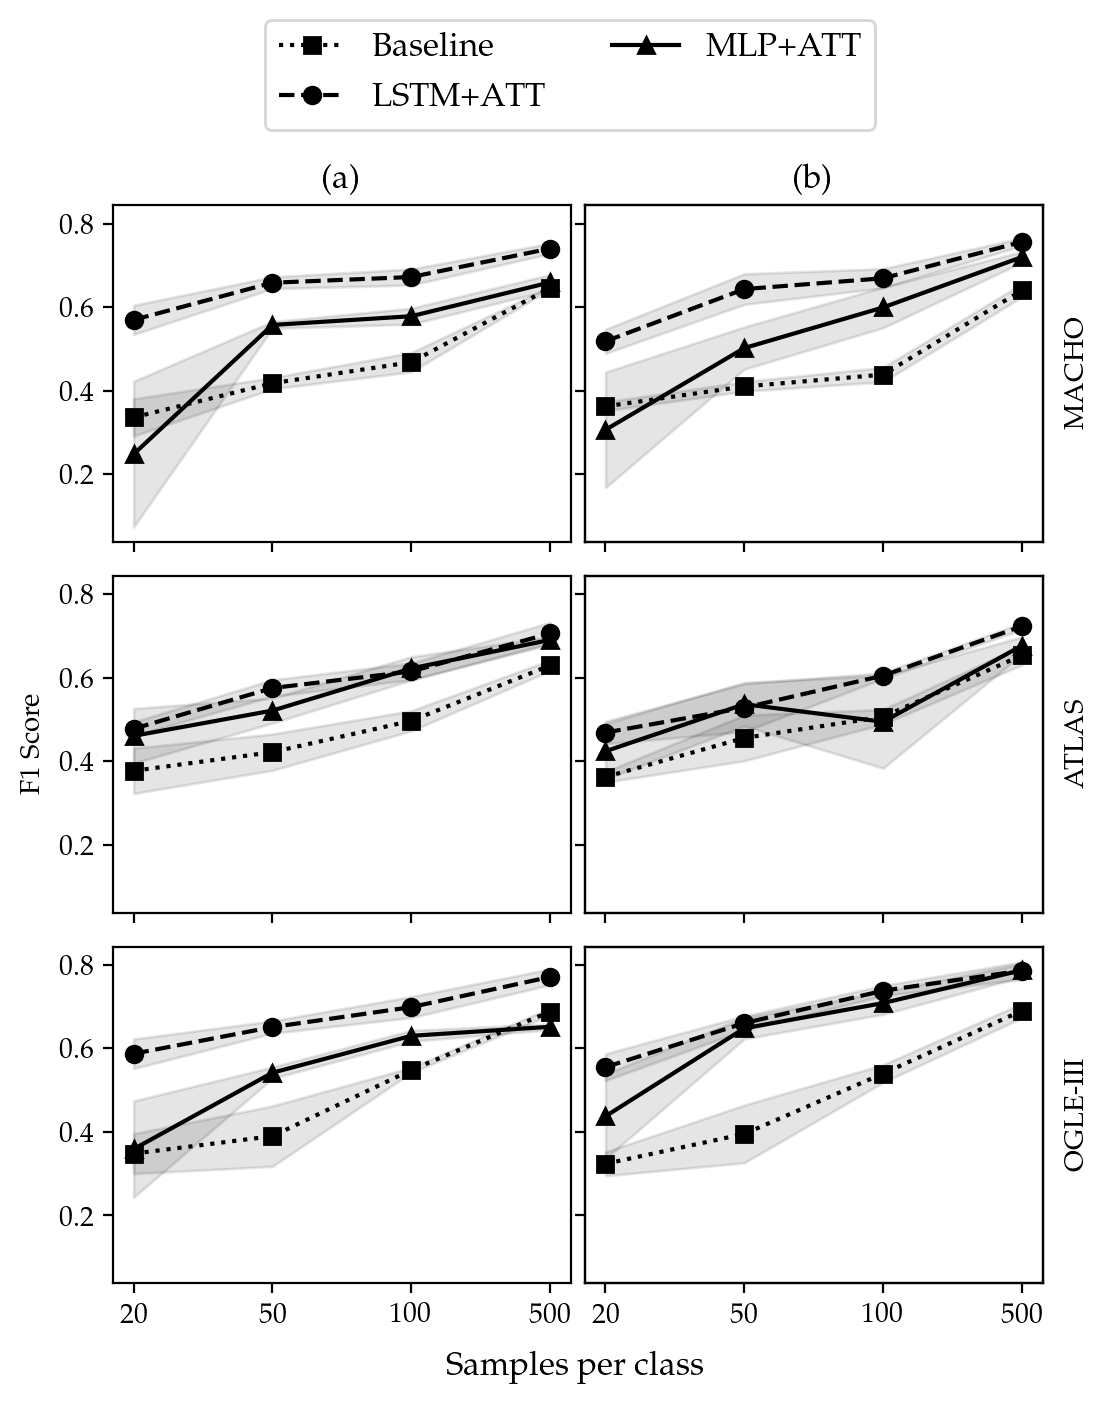

In [38]:
fig, axes = plt.subplots(3,2, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03},
                         sharey=True, sharex=True, dpi=200)

for master_name in ['ztfg']:
    experiments_config = './presentation/experiments/astromer_0/config_files/'+master_name
    metrics = collect_metrics(experiments_config, step='classification', cases=['a', 'b'])
    print(metrics)
    metrics = metrics.replace({'mlp_att':'MLP+ATT', 'lstm_att':'LSTM+ATT', 'lstm':'Baseline'})
    
    
    for row, (dataset_name, frame_0) in enumerate(metrics.groupby('ft_data')):
        metrics_by_case = frame_0.groupby('case')
        for col, (sci_case, frame_1) in enumerate(metrics_by_case):

            metrics_by_model = frame_1.groupby('model')
            best_baseline = []
            for model_name, frame_2 in metrics_by_model:                    
                frame_2['spc'] = frame_2['file'].apply(lambda x: int(x.split('.')[1]))

                metrics_by_spc = frame_2.groupby('spc')
                model_metrics = []
                for spc, frame_3 in metrics_by_spc:
                    mean = frame_3[selected_metric].astype(float).mean()
                    std = frame_3[selected_metric].astype(float).std()
                    model_metrics.append((float(spc), mean, std))

                sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
                sorted_metrics = np.vstack(sorted_metrics)
                
                x_range = range(len(sorted_metrics[:, 0]))
                axes[row][col].plot(x_range, 
                               sorted_metrics[:, 1], 
                               marker=styles[model_name]['marker'], 
                               color='k',
                               linestyle=styles[model_name]['linestyle'],
                               label=model_name)
                axes[row][col].fill_between(x_range, 
                                       sorted_metrics[:, 1]+sorted_metrics[:, 2], 
                                       sorted_metrics[:, 1]-sorted_metrics[:, 2],
                                       color='k', alpha=0.1)
                axes[row][col].set_xticks(x_range)
                axes[row][col].set_xticklabels([int(x) for x in sorted_metrics[:, 0]])
                
                if model_name == 'Baseline':
                    best_baseline.append(np.max(sorted_metrics[:, 1]))
    
            if col == 1:
                ax2 = axes[row][col].twinx()     
                ax2.set_yticks([])
                ax2.set_ylabel(ft_names_changed[dataset_name])

#             axes[row][col].axhline(y=np.max(best_baseline), 
#                                    color='red', 
#                                    linestyle='--', 
#                                    linewidth=1, 
#                                    label='Best Baseline')
#             axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])
            
axes[0][0].set_title('(a)')
axes[0][1].set_title('(b)')
axes[1][0].set_ylabel('F1 Score')

axes[0][0].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
if selected_metric == 'acc':
    axes[0][0].set_ylabel('Accuracy', fontsize=12)


fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)
plt.show()